# Donald Trump's tweets sentiment analysis and correlation with approval ratings

## Imports and API initialization

In [1]:
import tweepy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import datetime
import json
import logging
import os

In [2]:
logging.basicConfig(filename='logfile.log', level=logging.DEBUG, 
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

n_tweets = 500
name = 'realDonaldTrump'

start_date = datetime.datetime(2018, 12, 18, 0, 0, 0)
end_date = datetime.datetime(2019, 2, 19, 0, 0, 0)

consumer_key = ''
consumer_secret = ''

oauth_token = ''
oauth_token_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(oauth_token, oauth_token_secret)

# the are rate limits for the frequency of API calls for twitter, 
# wait_on_rate_limit flag helps us not to worry about it while collecting the data
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [3]:
print(api.me().name)

Andrei


## Tweets collection

Now we collect the Trumps tweets from the specified date range. If already collected, read from file

In [4]:
def collect_tweets(tweets, file):
    """
    collect all tweets for the specified account and time range,
    save results to file
    
    """
    tweets_temp = api.user_timeline(screen_name=name, count=n_tweets)
    for tweet in tweets_temp:
        if tweet.created_at < end_date and tweet.created_at > start_date:
            tweets.append(tweet._json)

    while (tweets_temp[-1].created_at > start_date):
        tweets_temp = api.user_timeline(
            screen_name=name, count=n_tweets, max_id=tweets_temp[-1].id)
        for tweet in tweets_temp:
            if tweet.created_at < end_date and tweet.created_at > start_date:
                tweets.append(tweet._json)

    json.dump(tweets, file, indent=2)

In [5]:
%%time
if os.path.isfile('tweets.json') and not os.stat('tweets.json').st_size == 0:
    logging.info('File tweets.json already exists! Reading the file..')
    file = open('tweets.json', 'r', encoding='utf8')
    tweets = json.load(file)
else:
    logging.info('Creating tweets.json, collecting tweets..')
    file = open('tweets.json', 'w', encoding='utf8')
    tweets = []
    collect_tweets(tweets, file)
    file.close()

CPU times: user 37.2 ms, sys: 9.01 ms, total: 46.3 ms
Wall time: 45.4 ms


In [6]:
df = pd.DataFrame(data=[tweet['text'] for tweet in tweets], columns=['Text'])
df.head(10)

,Text
0,I ask every member of the Maduro regime: End t...
1,The people of Venezuela are standing for FREED...
2,We are here to proclaim that a new day is comi...
3,RT @FLOTUS: A beautiful ceremony at @Nicklaus4...
4,"Hope you are enjoying your President’s Day, ou..."
5,“This was an illegal coup attempt on the Presi...
6,Great analysis by @foxandfriends!
7,....There is a lot of explaining to do to the ...
8,"Wow, so many lies by now disgraced acting FBI ..."
9,"Wow, so many lies by now disgraced acting FBI ..."


Let's see what attributes available for each tweet object

In [7]:
print('id:',tweets[0]['id'])
print('date:',tweets[0]['created_at'])
print('likes:',tweets[0]['favorite_count'])
print('retweets:',tweets[0]['retweet_count'])
print(tweets[0]['entities'])

id: 1097625026801688579
date: Mon Feb 18 22:32:53 +0000 2019
likes: 149136
retweets: 41622
{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/zN1R1Vl2af', 'expanded_url': 'https://twitter.com/i/web/status/1097625026801688579', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]}


Now let's add interesting attributes to the dataframe

In [8]:
df['len'] = np.array([len(tweet['text']) for tweet in tweets])
df['id'] = np.array([tweet['id'] for tweet in tweets])
df['Date'] = np.array([tweet['created_at'] for tweet in tweets])
df['Likes'] = np.array([tweet['favorite_count'] for tweet in tweets])
df['RTs'] = np.array([tweet['retweet_count'] for tweet in tweets])
df.head()

,Text,len,id,Date,Likes,RTs
0,I ask every member of the Maduro regime: End t...,140,1097625026801688579,Mon Feb 18 22:32:53 +0000 2019,149136,41622
1,The people of Venezuela are standing for FREED...,130,1097624329154674689,Mon Feb 18 22:30:07 +0000 2019,111736,31172
2,We are here to proclaim that a new day is comi...,139,1097623506580357120,Mon Feb 18 22:26:51 +0000 2019,96296,30305
3,RT @FLOTUS: A beautiful ceremony at @Nicklaus4...,144,1097595165479448576,Mon Feb 18 20:34:14 +0000 2019,0,15884
4,"Hope you are enjoying your President’s Day, ou...",89,1097592331405066242,Mon Feb 18 20:22:58 +0000 2019,155576,24334


In [9]:
min(df.Date), max(df.Date)

('Fri Dec 21 03:13:54 +0000 2018', 'Wed Jan 30 21:58:38 +0000 2019')

In [10]:
df.shape

(649, 6)

# Collection of replies/comments

Now as we collected all Trump's tweets for the desired period, we can loop through them and actually collect people's reactions by getting the replies to these tweets

In [11]:
def collect_replies(tweets, file):
    """
    collect popular replies for all the collected tweets of the specified account,
    query get 100 tweets per iteration then compares with desired parameters.
    finally saves results to file.
    
    """
    for tweet in tweets:
        for i, reply in enumerate(
                tweepy.Cursor(
                    api.search,
                    q='to:' + name,
                    since_id=tweet['id'],
                    count=100,
                    result_type='popular').items()):
            if hasattr(reply, 'in_reply_to_status_id_str'):
                if reply.in_reply_to_status_id_str == tweet['id_str']:
                    logging.info('Found a reply to the tweet with id=',
                                 tweet['id_str'], 'text=' + reply.text)
                    replies.append(reply._json)
                    logging.info('Reply added to the list. Continue...')
    
    json.dump(replies, file, indent=2)

In [12]:
%%time
if os.path.isfile('replies.json') and not os.stat('replies.json').st_size == 0:
    logging.info('File replies.json already exists! Reading the file..')
    file = open('replies.json', 'r', encoding='utf8')
    replies = json.load(file)
else:
    logging.info('Creating replies.json, collecting tweets..')
    file = open('replies.json', 'w', encoding='utf8')
    replies = []
    collect_replies(tweets, file)
    file.close()

KeyboardInterrupt: 

## Data preprocessing

Now lets do some preprocessing of the tweets text to prepare it for the sentiment analysis

In [ ]:
# # remove unicode accents with ascii
# df['Text'] = df['Text'].apply(lambda s: unidecode.unidecode(str(s)))

# # remove only punctuation
# df['Text'] = df['Text'].apply(lambda s: re.sub(r'[^\w\s]', '', s))

# #removing links and special characters
# df['Text'] = df['Text'].apply(lambda s: re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', '', s)

## Sentiment Analysis

Now we'll calculate the sentiment intensity for each of Trump's tweets using VADER which is especially tailored to work with social media texts

In [33]:
analyzer = SentimentIntensityAnalyzer()

sentiment_intensity = df['Text'].apply(lambda s: analyzer.polarity_scores(s))
df = pd.concat([df, sentiment_intensity.apply(pd.Series)], axis=1)
df.head()

,Text,len,id,Date,Likes,RTs,neg,neu,pos,compound
0,I ask every member of the Maduro regime: End t...,140,1097625026801688579,Mon Feb 18 22:32:53 +0000 2019,149136,41622,0.326,0.674,0.000,-0.8481
1,The people of Venezuela are standing for FREED...,130,1097624329154674689,Mon Feb 18 22:30:07 +0000 2019,111736,31172,0.000,0.714,0.286,0.8412
2,We are here to proclaim that a new day is comi...,139,1097623506580357120,Mon Feb 18 22:26:51 +0000 2019,96296,30305,0.000,1.000,0.000,0.0000
3,RT @FLOTUS: A beautiful ceremony at @Nicklaus4...,144,1097595165479448576,Mon Feb 18 20:34:14 +0000 2019,0,15884,0.000,0.554,0.446,0.9286
4,"Hope you are enjoying your President’s Day, ou...",89,1097592331405066242,Mon Feb 18 20:22:58 +0000 2019,155576,24334,0.000,0.516,0.484,0.8553


Now lets take a look at the distribution of positive/negative tweets

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, "Trump's positive tweets")

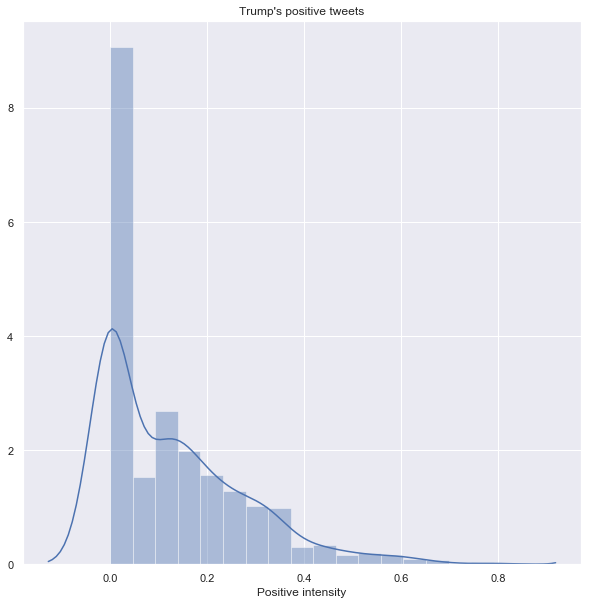

In [42]:
plt.figure(figsize=(10,10))
sns.distplot(df['pos'])
plt.xlabel('Positive intensity')
plt.title('Trump\'s positive tweets')

Text(0.5, 1.0, "Trump's negative tweets")

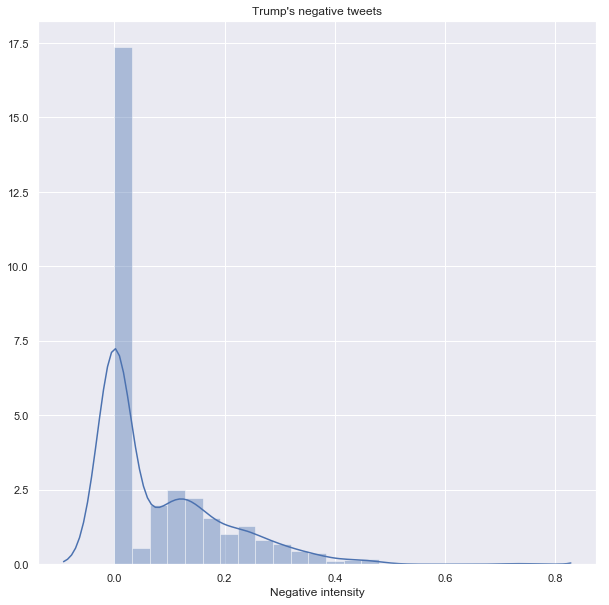

In [45]:
plt.figure(figsize=(10,10))
sns.distplot(df['neg'])
plt.xlabel('Negative intensity')
plt.title('Trump\'s negative tweets')

Text(0.5, 1.0, "Trump's neutral tweets")

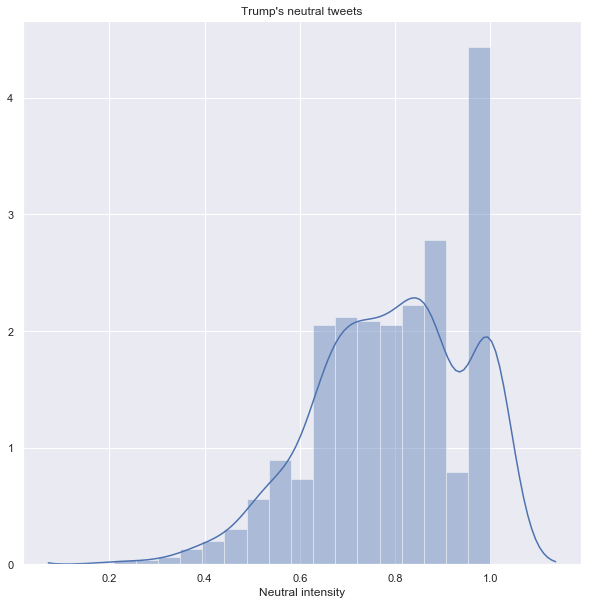

In [46]:
plt.figure(figsize=(10,10))
sns.distplot(df['neu'])
plt.xlabel('Neutral intensity')
plt.title('Trump\'s neutral tweets')

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, "Trump's mixed tweets")

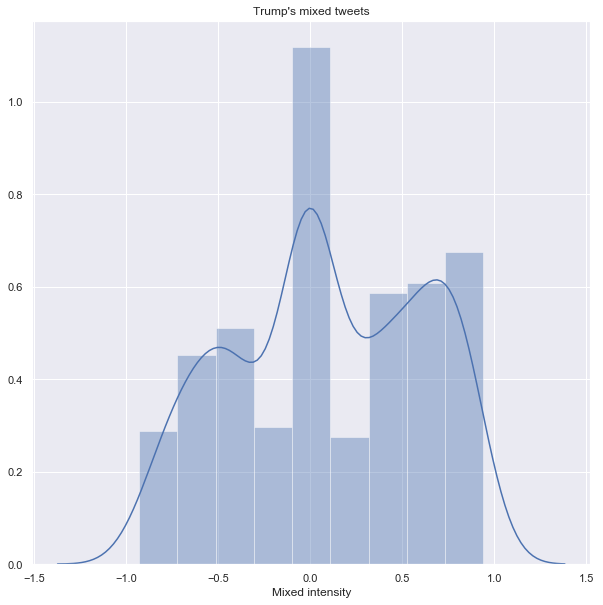

In [47]:
plt.figure(figsize=(10,10))
sns.distplot(df['compound'])
plt.xlabel('Mixed intensity')
plt.title('Trump\'s mixed tweets')